# Portfolio Optmization 
This script utilizes Markowitz optimization to construct a portfolio consisting of 5 stocks selected from the CAC 40 stocks. The goal is to optimize the portfolio's performance by considering the risk and return characteristics of the individual stocks.

### Libraries installation and importation

In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import seaborn as sns
import yfinance as yf
import datetime as dt

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

### Dates & Other Constants
- Defining the start and end dates for the stock data.

In [30]:
# Define path to files
path="/Users/vince/ML_2023/Markowitz Portfolio Optimization/Stocks/"
# Start date defaults
S_YEAR = 2017
S_MONTH = 1
S_DAY = 3
S_DATE_STR = "2017-01-03"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

# End date defaults
E_YEAR = 2023
E_MONTH =2
E_DAY = 15
E_DATE_STR = "2023-02-15"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)


### Get Stock File Names in a List
- Retrieving the stock file names for the CAC 40 stocks.


In [31]:
tickers=['ATO.PA','WLN.PA','BN.PA','AIR.PA','AI.PA','DG.PA','VIV.PA','SU.PA','AC.PA','ORA.PA','ACA.PA','ML.PA','BNP.PA','SGO.PA','ENGI.PA','CAP.PA','EN.PA','GLE.PA','VIE.PA','RI.PA','SAN.PA','CA.PA','KER.PA','SW.PA','MC.PA','LR.PA','HO.PA','OR.PA']
stocks_not_downloaded = []
missing_stocks = []

### Saving Stock Data to CSV Files
- Downloading the stock data from Yahoo Finance and saving it as CSV files.

In [32]:
def save_to_csv_from_yahoo(folder, ticker, S_YEAR,S_MONTH ,S_DAY ,E_YEAR,E_MONTH,E_DAY):
    for ticker in tickers:
        try: 
            print("Get Data for :", ticker)
            df = yf.download(ticker, start=S_DATE_DATETIME, end=E_DATE_DATETIME)['Adj Close']
            df.to_csv(folder + ticker + '.csv')
        except Exception as ex:
            stocks_not_downloaded.append(ticker)
            print("Couldn't Get Data for :", ticker)
def get_df_from_csv(folder, ticker):
    try:
        df = pd.read_csv(folder + ticker + '.csv')
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df
def get_column_from_csv(file, col_name):
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df[col_name]
    
def delete_unnamed_cols(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df
def save_dataframe_to_csv(df, path, ticker):
    df.to_csv(path + ticker + '.csv')
    
    
def add_daily_return_to_df(df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    df.to_csv("C:/Users/vince/ML_2023/Finance/Stocks/" + ticker + '.csv')
    return df  

# Return 1st Valid Date in Dataframe
def get_valid_dates(df, sdate, edate):  
    try:
        mask = (df['Date'] > sdate) & (df['Date'] <= edate) 
        sm_df = df.loc[mask]
        sm_df = sm_df.set_index(['Date'])
        sm_date = sm_df.index.min()
        last_date = sm_df.index.max()
        date_leading = '-'.join(('0' if len(x)<2 else '')+x for x in sm_date.split('-'))
        date_ending = '-'.join(('0' if len(x)<2 else '')+x for x in last_date.split('-'))
    except Exception:
        print("Date Corrupted")
    else:
        return date_leading, date_ending
    
# Returns Return on Investment over Time
def roi_between_dates(df, sdate, edate):
    try: 
        start_val = df.loc[sdate,'Adj Close'] 
        end_val = df.loc[edate,'Adj Close']
        roi = ((end_val - start_val) / start_val)
    except Exception:
        print("Data Corrupted")
    else:
        return roi
# Get Mean Between Dates
def get_mean_between_dates(df, sdate, edate):
    mask = (df['Date'] > sdate) & (df['Date'] <= edate)
    return df.loc[mask]["Adj Close"].mean()
def get_sd_between_dates(df, sdate, edate):
    mask = (df['Date'] > sdate) & (df['Date'] <= edate)
    return df.loc[mask]["Adj Close"].std()
def get_cov_between_dates(df, sdate, edate):
    mean = get_mean_between_dates(df, sdate, edate)
    sd = get_sd_between_dates(df, sdate, edate)
    return sd / mean
def get_rois_for_stocks(stock_df):
    # Will hold all tickers & stock rois
    tickers = []
    rois = []

    # iterrows provides the index and column for each row in the DF
    for index, row in stock_df.iterrows():
        df = get_df_from_csv(path,row['Ticker'])
    
        # If we can't find the ticker delete it from the dataframe
        if df is None:
            pass
            # print(row['Symbol'], " is not available")
        else:
            tickers.append(row['Ticker'])
            sdate, edate = get_valid_dates(df, S_DATE_STR, E_DATE_STR)
            df = df.set_index(['Date'])
            roi = roi_between_dates(df, sdate, edate)
            rois.append(roi)
    return pd.DataFrame({'Ticker':tickers, 'ROI':rois})
def get_stock_price_on_date(ticker, date):
    df = get_df_from_csv(path, ticker)
    df = df.set_index(['Date'])
    return df.loc[date,'Adj Close']
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(path, x)
        df['Date'] = pd.to_datetime(df['Date'])
        # Use a mask to grab data between defined dates
        mask = (df['Date'] >= sdate) & (df['Date'] <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df
def calc_diversifiable_risk(df, tickers, weights):
    # Gets number of days
    days = len(mult_df.index)
    # Calculate covariance of portfolio
    port_covar = np.dot(weights.T, np.dot(df.cov() * days, weights)) 
    
    i = 0
    while i < len(tickers):
        wt_sq = weights[i] ** 2
        stk_var = mult_df[tickers[i]].var() * days
        wt_var = wt_sq * stk_var
        port_covar = port_covar - wt_var
        i += 1
    return port_covar

### Preparing Stock Dataframes
- Processing the downloaded stock data by adding daily returns and removing unnecessary columns.

In [5]:
save_to_csv_from_yahoo(path,tickers,S_YEAR,S_MONTH ,S_DAY ,E_YEAR,E_MONTH,E_DAY)

Get Data for : ATO.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : WLN.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : BN.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : AIR.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : AI.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : DG.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : VIV.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : SU.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : AC.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : ORA.PA
[*********************100%***********************]  1 of 1 completed
Get Data for : ACA.PA
[*********************100%***********************]  1 of 1 completed
Get 

In [6]:
for ticker in list(tickers):
    stock_df=get_df_from_csv(path, ticker)
    stock_df=add_daily_return_to_df(stock_df,ticker)
    stock_df=delete_unnamed_cols(stock_df)
    save_dataframe_to_csv(stock_df,path, ticker)

### 11 Stock Market Sectors

In [7]:
sec_df = pd.read_csv('C:/Users/vince/ML_2023/Finance/cac.csv')
sec_df

# Get Industrials DF
indus_df = sec_df.loc[sec_df['Sector'] == "Industrials"]
health_df = sec_df.loc[sec_df['Sector'] == "Health Care"]
it_df = sec_df.loc[sec_df['Sector'] == "Information Technology"]
comm_df = sec_df.loc[sec_df['Sector'] == "Communication Services"]
staple_df = sec_df.loc[sec_df['Sector'] == "Consumer Staples"]
discretion_df = sec_df.loc[sec_df['Sector'] == "Consumer Discretionary"]
utility_df = sec_df.loc[sec_df['Sector'] == "Utilities"]
financial_df = sec_df.loc[sec_df['Sector'] == "Financials"]
material_df = sec_df.loc[sec_df['Sector'] == "Materials"]
restate_df = sec_df.loc[sec_df['Sector'] == "Real Estate"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]

### Get ROI for All Stocks
- Calculating the return on investment (ROI) for each stock and storing the results in dataframes based on sector.

## Returns a DF with ROIs for all Stocks


In [8]:
industrial = get_rois_for_stocks(indus_df)
staple = get_rois_for_stocks(staple_df)
health_care = get_rois_for_stocks(health_df)
it = get_rois_for_stocks(it_df)
commun = get_rois_for_stocks(comm_df)
staple = get_rois_for_stocks(staple_df)
discretion = get_rois_for_stocks(discretion_df)
utility = get_rois_for_stocks(utility_df)
finance = get_rois_for_stocks(financial_df)
material = get_rois_for_stocks(material_df)
restate = get_rois_for_stocks(restate_df)
energy = get_rois_for_stocks(energy_df)

In [9]:
industrial.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
0,AIR.PA,1.013833


In [10]:
health_care.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
2,HO.PA,0.622080
1,SAN.PA,0.413252
0,ML.PA,0.344354


In [11]:
it.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
0,CA.PA,-0.178132


In [12]:
commun.sort_values(by=['ROI'], ascending=False).head(20)

,Ticker,ROI


In [13]:
staple.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
0,VIE.PA,1.178104
1,SW.PA,-0.069677


In [14]:
discretion.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
5,KER.PA,2.256758
3,CAP.PA,1.522966
0,AI.PA,1.074513
4,RI.PA,1.017125
1,DG.PA,0.989983


In [15]:
utility.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
2,ENGI.PA,0.657194
3,EN.PA,0.250677
1,ORA.PA,-0.073876
0,ATO.PA,-0.833851


In [16]:
finance.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
2,BNP.PA,0.530304
1,ACA.PA,0.342374
0,BN.PA,0.041628
3,GLE.PA,-0.113384


In [17]:
material.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
1,OR.PA,1.545751
0,WLN.PA,0.523254


In [18]:
restate.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI


In [19]:
energy.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
0,SU.PA,1.708394
1,SGO.PA,0.431337


### Portfolio List
- Defining the list of stocks to be included in the portfolio.
- Merging the stock dataframes for the portfolio stocks based on the specified column name.

In [20]:
port_list = ["AIR.PA","WLN.PA","SU.PA","KER.PA","SAN.PA"]
mult_df_close = merge_df_by_column_name('Adj Close',  S_DATE_STR, E_DATE_STR, *port_list)
mult_df = merge_df_by_column_name('daily_return',  S_DATE_STR, E_DATE_STR, *port_list)

## Markowitz Portfolio Optimization

### Returns Portfolio Weight
- Calculating the portfolio weights based on the investment in each stock.

<AxesSubplot:>

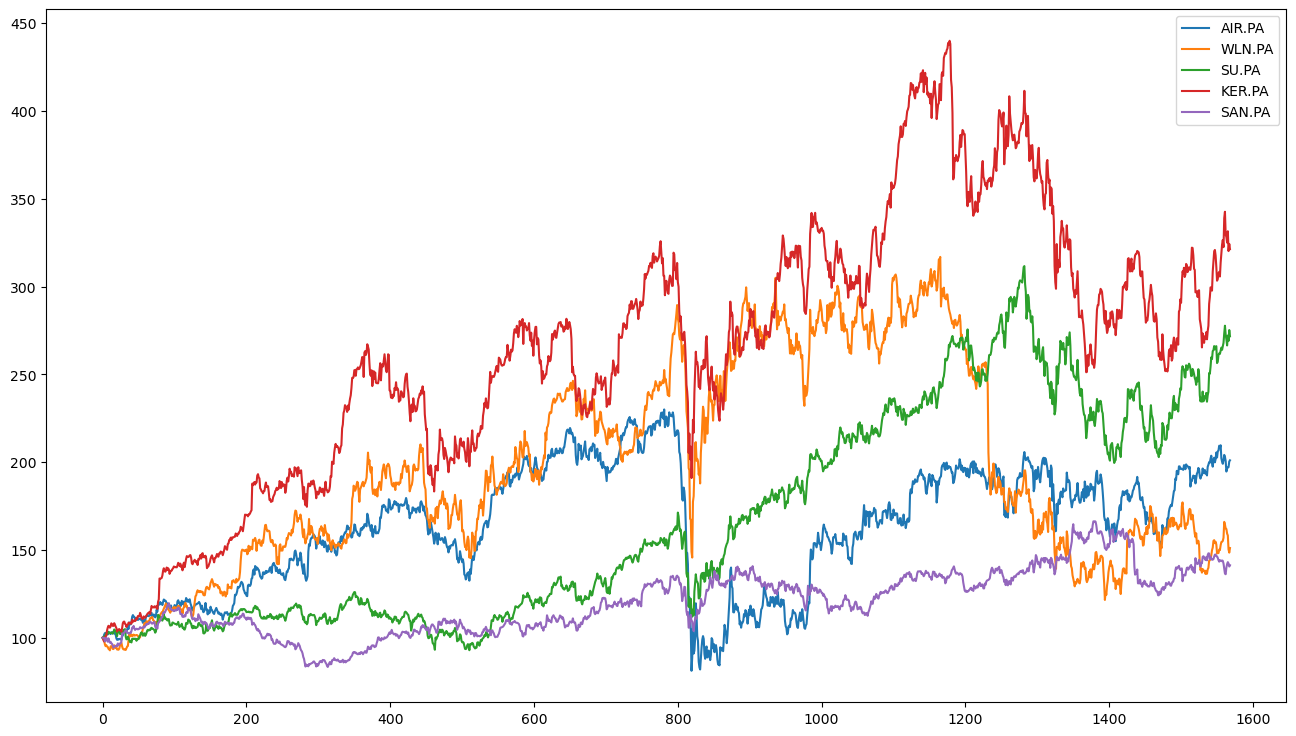

In [21]:
(mult_df_close/ mult_df_close.iloc[0] * 100).plot(figsize=(16, 9))

In [22]:
# Get the number of samples
days = len(mult_df.index)
days
returns = np.log(mult_df_close / mult_df_close.shift(1))
mean_ret = returns.mean() * days 
mean_ret

AIR.PA    0.698909
WLN.PA    0.413048
SU.PA     1.000188
KER.PA    1.168079
SAN.PA    0.346114
dtype: float64


### Check for Correlation
- Calculating and visualizing the correlation matrix for the portfolio stocks.

Text(0.5, 1.0, 'Correlation Matrix')

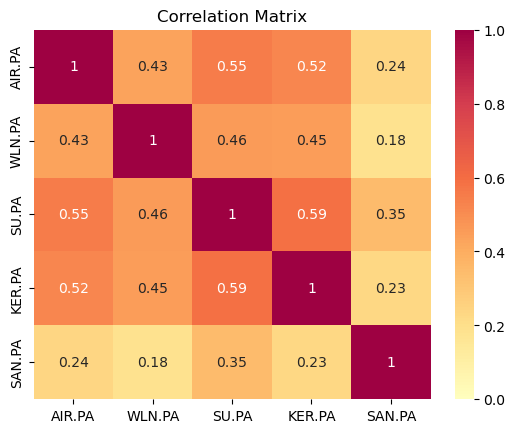

In [23]:
fig = plt.subplots()

sns.heatmap(returns.corr(), cmap = 'Spectral_r',vmax=1,vmin=0,center=0,annot=True)
plt.title('Correlation Matrix')

## Returns Portfolio Weight


In [24]:
p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list

risk_free_rate = 0.0125

for x in range(10000):
    # Generate random weight where the sum equal 1
    p_weights = np.random.random(5)
    p_weights /= np.sum(p_weights)
    
    # Calculate the return of the portfolio using those weights
    ret_1 = np.sum(p_weights * returns.mean()) * days
    p_ret.append(ret_1)
    
    #  Calculate the volatility or standard deviation
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * days, p_weights)))
    p_vol.append(vol_1)
    
    # Get Sharpe ratio
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)
    
    # Store the weights for each portfolio
    p_wt.append(p_weights)
    
# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

(array([0.73719393, 0.82959081, 0.54754509, ..., 0.74646209, 0.58945168,
        0.51119807]),
 array([0.57874511, 0.65448347, 0.63607998, ..., 0.58602318, 0.55823083,
        0.54637103]),
 array([1.25218151, 1.24845141, 0.84116009, ..., 1.25244549, 1.03353604,
        0.91274619]),
 array([[0.3269273 , 0.04320039, 0.21653187, 0.15964449, 0.25369595],
        [0.33771066, 0.12916826, 0.25547583, 0.22943605, 0.0482092 ],
        [0.02737512, 0.54198833, 0.22341577, 0.01139387, 0.19582692],
        ...,
        [0.04514119, 0.31870847, 0.22395021, 0.26352716, 0.14867298],
        [0.17049461, 0.30732629, 0.24206727, 0.00521617, 0.27489564],
        [0.06630414, 0.39453339, 0.17017126, 0.00484198, 0.36414923]]))

## Sharpe Ratio
The Sharpe Ratio identifies the portfolio that offers the optimal return-to-risk trade-off. When returns rise, the Sharpe Ratio also increases, but as Standard Deviation increases, the Sharpe Ratio declines.


### Plotting Optimal Portfolio
- Plotting the optimal portfolio on the efficient frontier.

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

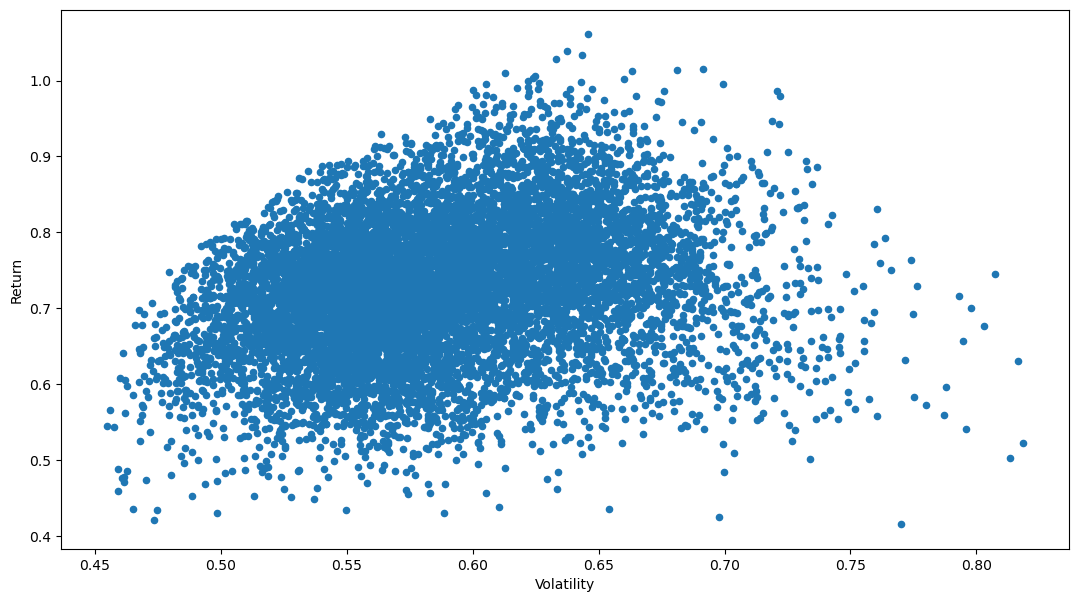

In [25]:
# Create a dataframe with returns and volatility
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})
ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(13, 7))


### Selecting Optimal Portfolio
- Selecting the optimal portfolio based on the maximum Sharpe ratio or minimum volatility.


In [26]:
# Return the index of the largest Sharpe Ratio
SR_idx = np.argmax(p_SR)

# Find the ideal portfolio weighting at that index
i = 0
while i < len(port_list):
    print("Stock : %s : %2.2f" % (port_list[i], (p_wt[SR_idx][i] * 100)))
    i += 1
    
wts=p_wt[SR_idx]
# Find volatility of that portfolio
print("\nVolatility :", p_vol[SR_idx])
      
# Find return of that portfolio
print("Return :", p_ret[SR_idx])

Stock : AIR.PA : 0.39
Stock : WLN.PA : 4.56
Stock : SU.PA : 46.26
Stock : KER.PA : 43.44
Stock : SAN.PA : 5.35

Volatility : 0.6127328841317586
Return : 1.0101548018342565


### Calculating Portfolio Variance
- Calculating the portfolio variance using the weighted covariance of the stocks.

In [27]:
days = len(mult_df.index)
daysport_var = np.dot(wts.T, np.dot(mult_df.cov() * days, wts))
print("Portfolio Covariance :", daysport_var)

Portfolio Covariance : 0.3739893096390966


# Different Types of Risk


### Calculating Diversifiable Risk
- Calculating the diversifiable risk of the portfolio by subtracting the weighted variances of individual stocks.

In [28]:
# Diversifiable Risk = Portfolio Variance - All Weighted Variances
div_risk = calc_diversifiable_risk(mult_df, port_list, wts)
div_risk


0.16103969591189737

### Calculating Non-Diversifiable Risk
- Calculating the non-diversifiable risk of the portfolio by subtracting the diversifiable risk from the total portfolio variance.

In [29]:
print("Systematic Risk :", (daysport_var - div_risk))

Systematic Risk : 0.21294961372719923
